<a href="https://colab.research.google.com/github/irvyn/image-enhancement-colab/blob/main/image_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Enhancement

## Table of Contents
1. [Libraries](#libraries)
2. [Histogram Equalization](#hist)
3. [Denoising with Filters](#denoising)
4. [Challenge](#challenge)

# Introduction to Image Enhancement

Image processing is a fundamental area in computer graphics, with applications in film, visual effects, advertising, simulators, architecture, scientific research, and video games. These industries drive the need to generate increasingly complex and high-quality digital images.

One common challenge in this field is the synthesis and storage of complex visual signals, such as textures or point distributions. In many cases, there are no efficient algorithms to generate these signals, and storing them can be costly. Tile-based methods offer a practical solution: they allow the generation of large amounts of visual information from a small set of predefined tiles.

For example, in interactive video games, a small texture is repeated to simulate a larger surface. Although this technique saves resources, it can produce visual artifacts such as noticeable repetitions or visible seams between tiles. The challenge is to make these generated signals as similar as possible to the originals, without perceivable repetitive patterns.

---

## Image Enhancement and Noise Reduction

Noise reduction is a key aspect of image processing. Noise appears as unexpected variations in brightness or color and can be caused by external factors during capture. To improve visual quality, preprocessing techniques are applied, such as:

- Noise reduction  
- Binarization  
- Contrast enhancement  

One of the most effective techniques for this purpose is the **CLAHE (Contrast Limited Adaptive Histogram Equalization)** algorithm. Unlike traditional histogram equalization, CLAHE works on small regions of the image (tiles), which allows improving local contrast without amplifying noise.

This method is mainly applied to the luminance channel in color images, achieving better results when working in the **HSV** color space instead of **BGR**.

Other techniques are also used, such as:

- **Bilinear interpolation**: estimates new pixel values from the nearest ones.  
- **Contrast stretching**: expands the dynamic range of the image to improve visibility.  

---

## Steps of the CLAHE Algorithm

1. Input image  
2. Segmentation into tiles  
3. Histogram calculation for each tile  
4. Application of TFM (Thresholded Function Mapping) to define the clip limit  
5. Contrast limitation according to the calculated limit  
6. Verification of image improvement  
7. Generation of the enhanced image  

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [29]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage import exposure
import skimage
from scipy.ndimage.filters import gaussian_filter as gauss
from scipy.ndimage.filters import median_filter as med
import cv2

/tmp/ipython-input-3972790099.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter as gauss
/tmp/ipython-input-3972790099.py:8: DeprecationWarning: Please import `median_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import median_filter as med


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


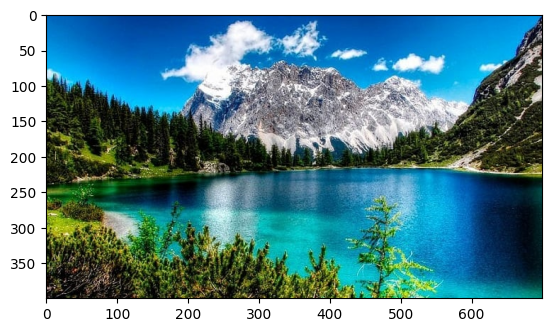

In [31]:
original_image = Image.open('data/image.jpg')
plt.imshow(original_image)
type(original_image)

# Save the image
np.save('data/img.npy', original_image)

#Load the image
original_image = np.load('data/img.npy')

## Histogram Equalization<a class="anchor" id="hist" ></a>

Let's look at the distribution of pixel values in the image.

Ideally, the image should have relatively even distribution of values, indicating good contrast and making it easier to extract analytical information.

An easy way to check this is to plot a histogram.

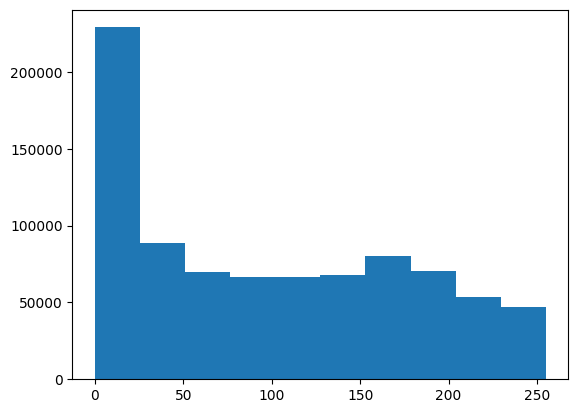

In [32]:
# Plot a histogram - we need to use ravel to "flatten" the 3 dimensions
plt.hist(original_image.ravel())
plt.show()

Another useful way to visualize the statistics of an image is as a cumulative distribution function (CDF) plot. Which shows the cumulative pixel intensity frequencies from 0 to 255.

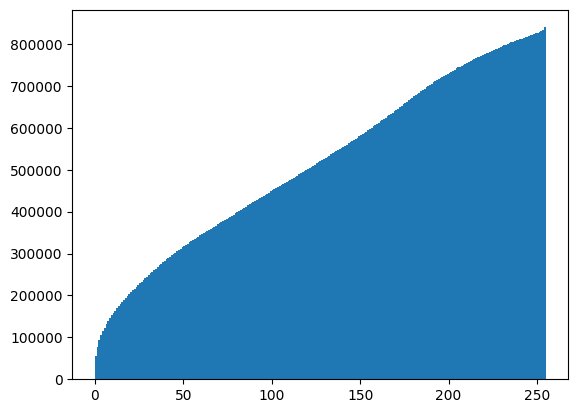

In [33]:
plt.hist(original_image.ravel(), bins=255, cumulative=True)
plt.show()

The histogram and CDF for our image show pretty uneven distribution - there's a lot of contrast in the image. Ideally we should equalize the values in the images we want to analyse to try to make our images more consistent in terms of the shapes they contain irrespective of light levels.

Histogram equalization is often used to improve the statistics of images. In simple terms, the histogram equalization algorithm attempts to adjust the pixel values in the image to create a more uniform distribution. The code in the cell below uses the  **exposure.equalize_hist** method from the **skimage** package to equalize the image.  

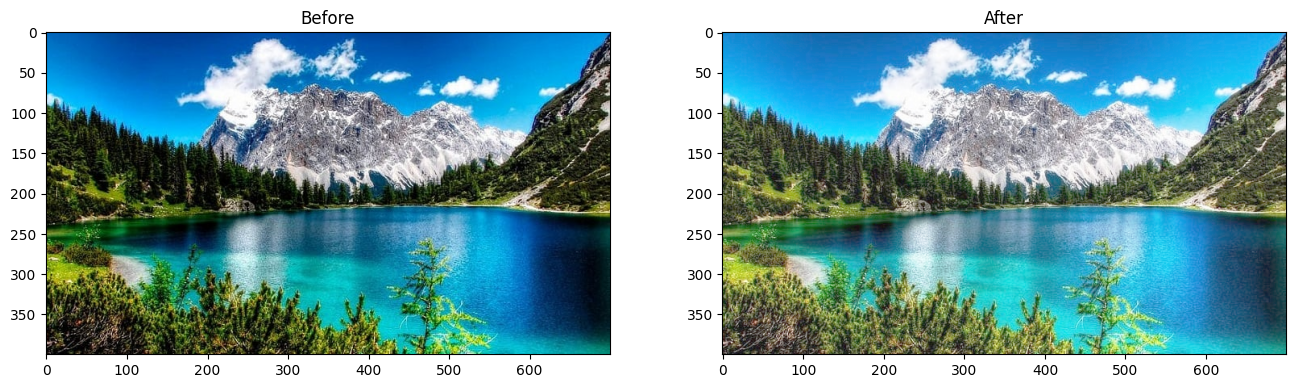

In [34]:
original_image_eq = exposure.equalize_hist(original_image)

fig = plt.figure(figsize=(16, 8))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(original_image)
a.set_title('Before')

# Subplot for processed image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(original_image_eq)
a.set_title('After')

plt.show()

As with most image operations, there's more than one way to do this. For example, you could also use the **PIL.ImgOps.equalize** method:

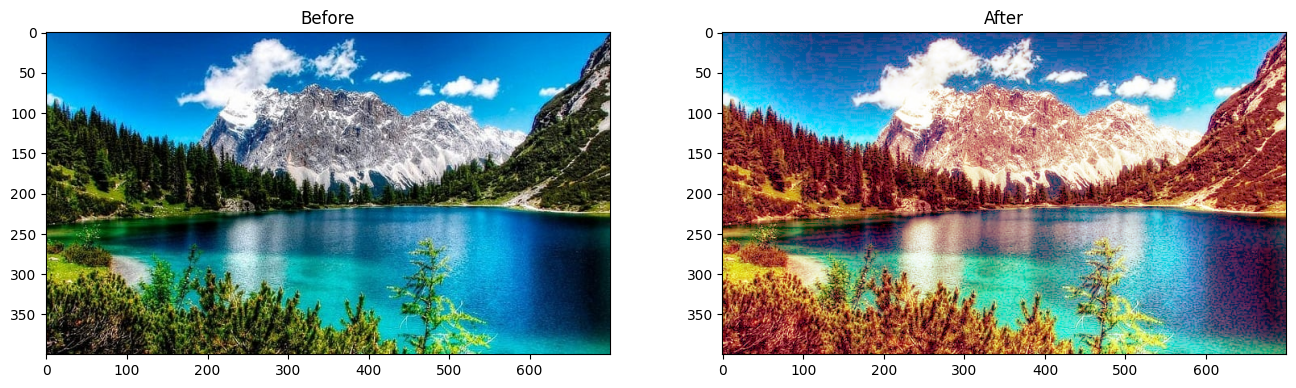

In [35]:

# Equalize the image - but we need to convert the numpy array back to the PIL image format
image_PIL_eq = ImageOps.equalize(Image.fromarray(original_image))

# Display using matplotlib

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(original_image)
a.set_title('Before')

# Subplot for processed image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(image_PIL_eq)
a.set_title('After')

plt.show()

Now let's see what that's done to the histogram and CDF plots:

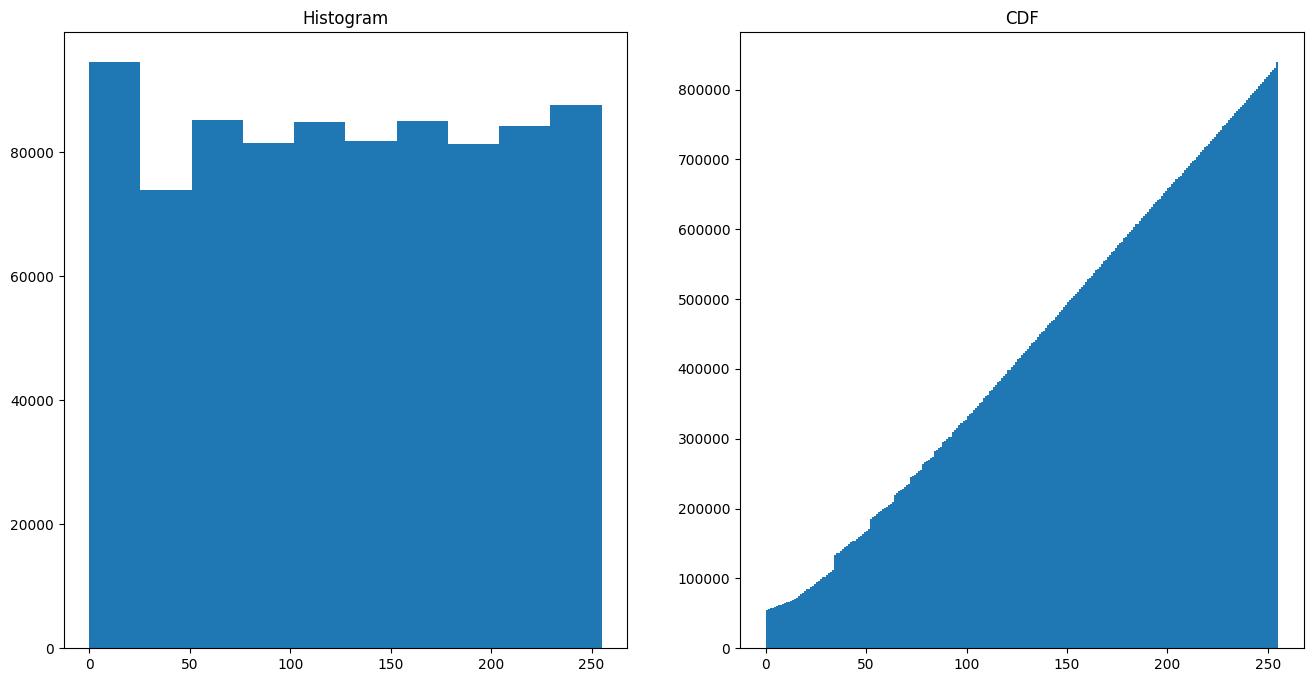

In [36]:
# Display histograms
img_eq = np.array(image_PIL_eq)

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.hist(img_eq.ravel())
a.set_title('Histogram')

# Subplot for processed image
a=fig.add_subplot(1,2,2)
imgplot = plt.hist(img_eq.ravel(), bins=255, cumulative=True)
a.set_title('CDF')

plt.show()

The pixel intensities are more evenly distributed in the equalized image. In particular, the cumulative density shows a straight diagonal cumulation; which is a good sign that the pixel intensity values have been equalized.

## Denoising with Filters <a class="anchor" id="denoising" ></a>

Often images need to be cleaned up to remove "salt and pepper" noise.

### Add Some Random Noise
Let's add some random noise to our image - such as you might see in a photograph taken in low light or at a low resolution.

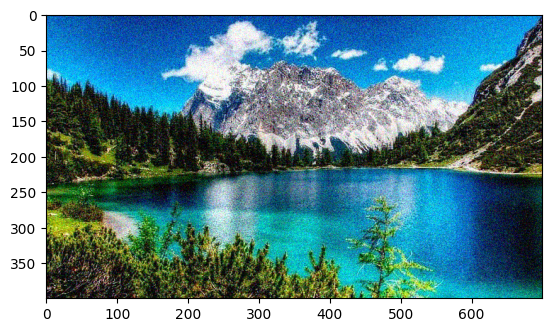

In [37]:
img_n = skimage.util.random_noise(original_image)
plt.imshow(img_n)

### Using a Gaussian Filter
A Gaussian filter applies a weighted average (mean) value for pixels based on the pixels that surround them.

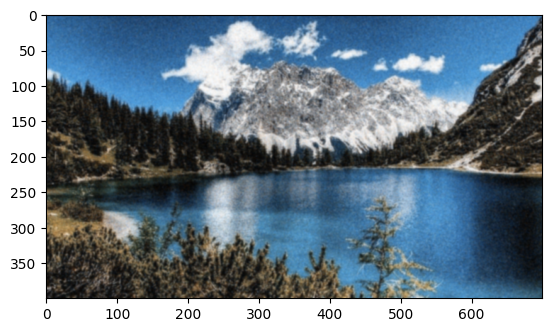

In [38]:
img3_gauss = gauss(img_n, sigma=1)
plt.imshow(img3_gauss)

### Using a Median Filter
The Gaussian filter results in a blurred image, which may actually be better for feature extraction as it makes it easier to find contrasting areas. If it's too blurred, we could try a median filter, which as the name suggests applies the median value to pixels based on the pixels around them.

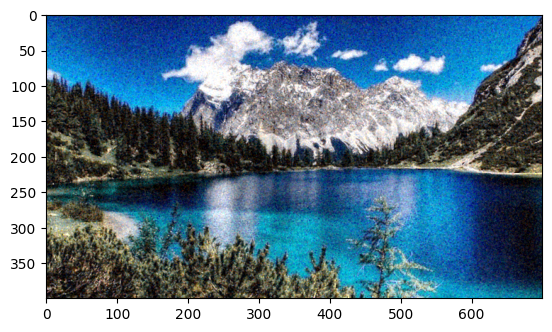

In [39]:
img_med = med(img_n, size=2)
plt.imshow(img_med)

## Challenge <a class="anchor" id="challenge" ></a>

Now, try solving this challenge, you must equalize different windows of the same image in a splitted way.

In [40]:
n = 4
slice('data/image.jpg', n)

slice('data/image.jpg', 4, None)

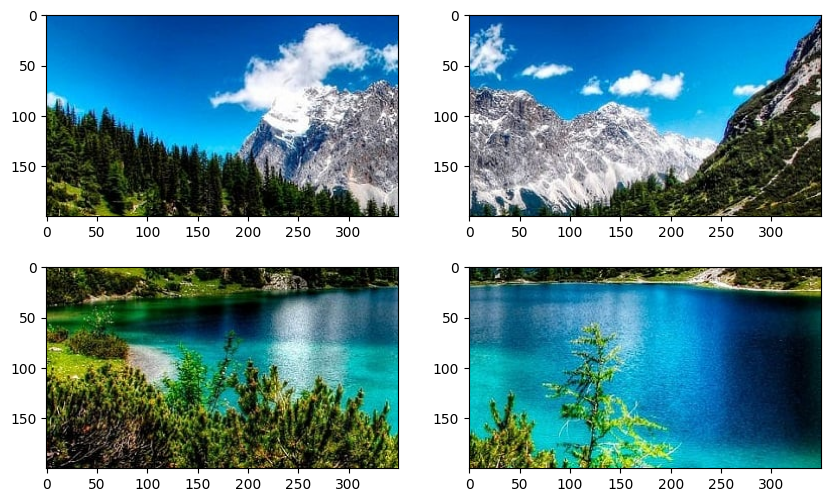

In [41]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(2,2,1)
img = Image.open(f'data/image_01_01.png')
plt.imshow(img)

plt.subplot(2,2,2)
img = Image.open(f'data/image_01_02.png')
plt.imshow(img)

plt.subplot(2,2,3)
img = Image.open(f'data/image_02_01.png')
plt.imshow(img)

plt.subplot(2,2,4)
img = Image.open(f'data/image_02_02.png')
plt.imshow(img)

plt.show()

# 1. Método tile-based histogram equalization

In [42]:
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt

# --- Equalize tiles and save them with _eq suffix ---
for r in (1, 2):
    for c in (1, 2):
        p = Path(f'data/image_{r:02d}_{c:02d}.png')   # Path to the original tile
        im = Image.open(p).convert('RGB')             # Convert to RGB for consistency
        im_eq = ImageOps.equalize(im)                 # Global equalization per tile
        im_eq.save(Path(f'data/image_{r:02d}_{c:02d}_eq.png'))  # Save equalized tile

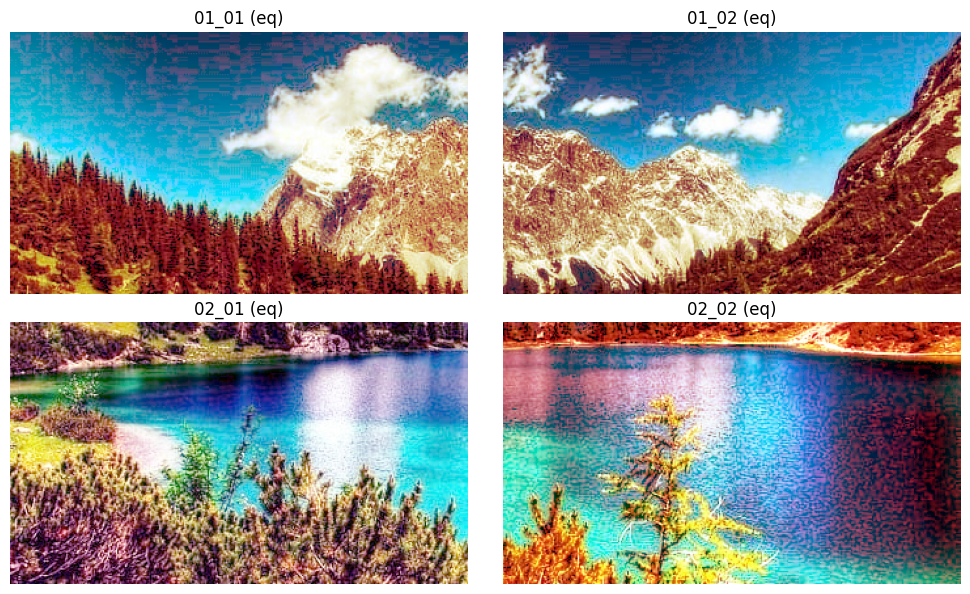

In [43]:
# --- Display equalized tiles in a grid ---
fig = plt.figure(figsize=(10, 6))
plt.subplot(2,2,1); plt.imshow(Image.open('data/image_01_01_eq.png')); plt.axis('off'); plt.title('01_01 (eq)')
plt.subplot(2,2,2); plt.imshow(Image.open('data/image_01_02_eq.png')); plt.axis('off'); plt.title('01_02 (eq)')
plt.subplot(2,2,3); plt.imshow(Image.open('data/image_02_01_eq.png')); plt.axis('off'); plt.title('02_01 (eq)')
plt.subplot(2,2,4); plt.imshow(Image.open('data/image_02_02_eq.png')); plt.axis('off'); plt.title('02_02 (eq)')
plt.tight_layout(); plt.show()

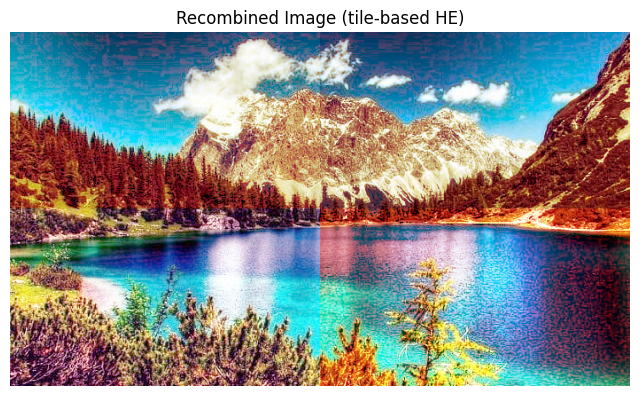

In [44]:
# --- Recompose mosaic from equalized tiles ---
base_dir = Path('data')
rows, cols = 2, 2
suffix = '_eq'  # suffix used when saving equalized tiles

# Open first tile to get size
first_tile = Image.open(base_dir / f'image_01_01{suffix}.png')
tile_w, tile_h = first_tile.size

# Create empty canvas of total size
canvas = Image.new('RGB', (cols * tile_w, rows * tile_h))

# Paste each tile in its corresponding position
for r in range(1, rows+1):
    for c in range(1, cols+1):
        tile_path = base_dir / f'image_{r:02d}_{c:02d}{suffix}.png'
        tile = Image.open(tile_path).convert('RGB')
        x, y = (c-1) * tile_w, (r-1) * tile_h
        canvas.paste(tile, (x, y))

# Display and save recombined image
plt.figure(figsize=(8, 6))
plt.imshow(canvas); plt.axis('off')
plt.title('Recombined Image (tile-based HE)')
plt.show()
canvas.save(base_dir / 'image_tile_based_equalized.png')

You can observe differences in the contrast between the blocks. How could this be improved?

It is expected that there are contrast differences between the blocks because each tile is equalized with its own histogram without considering its neighbors. This causes each region to have a different dynamic range, and when they are combined, borders and color changes become noticeable. To improve this, techniques such as interpolation between tiles and contrast limitation (for example, CLAHE) can be used, which smooth transitions and prevent one block from looking too different from another, achieving a more uniform and natural result.

# 2. Método del Sliding Window Adaptive Histogram Equalization (SWAHE)

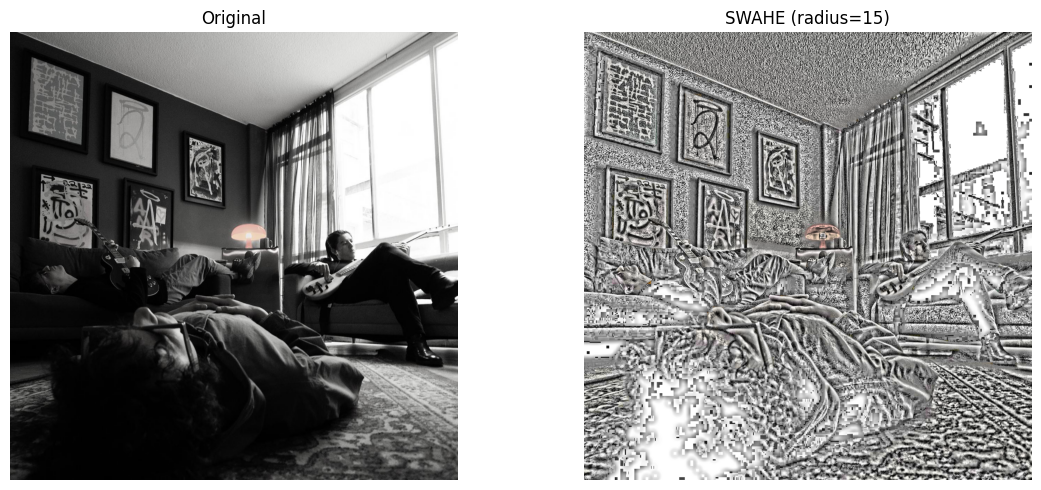

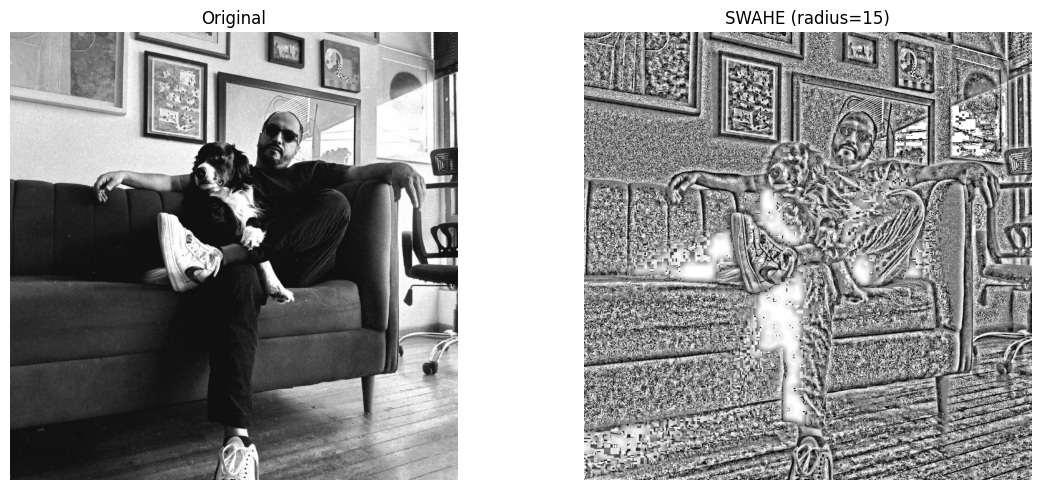

In [45]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color, util
from skimage.filters import rank
from skimage.morphology import disk

# --- Parameters ---
paths = ['data/lying.png', 'data/with_dog.png']
radius = 15  # neighborhood size; window ≈ (2*radius + 1)

# --- SWAHE (sliding window) on V in HSV ---
for p in paths:
    assert Path(p).exists(), f"File not found {p}"

    # Load as RGB (if B/W, expand to 3 channels)
    rgb = np.array(Image.open(p).convert('RGB'))

    # RGB uint8 [0..255] -> float [0..1] -> HSV
    rgb_f = rgb.astype(np.float32) / 255.0
    hsv = color.rgb2hsv(rgb_f)

    # rank.equalize operates on uint8: locally equalize the V channel (luminance)
    V_u8 = util.img_as_ubyte(hsv[..., 2])
    V_eq_u8 = rank.equalize(V_u8, footprint=disk(radius))

    # Reconstruction: equalized V -> HSV -> RGB uint8
    hsv[..., 2] = V_eq_u8.astype(np.float32) / 255.0
    rgb_swahe = np.clip(color.hsv2rgb(hsv) * 255.0, 0, 255).astype(np.uint8)

    # --- Side-by-side visualization ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.imshow(rgb);       plt.title('Original');                 plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(rgb_swahe); plt.title(f'SWAHE (radius={radius})'); plt.axis('off')
    plt.tight_layout(); plt.show()

# 3. CLAHE (contrast limited adaptive histogram equalization)

In [46]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Input paths and output ---
in_paths = [
    "data/lying.png",
    "data/with_dog.png",
]
out_dir = "data/output_clahe"
os.makedirs(out_dir, exist_ok=True)
print("Output:", os.path.abspath(out_dir))

Output: /content/data/output_clahe


In [47]:
def apply_clahe(gray_img: np.ndarray,
                clip_limit: float = 3.0,
                tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    """Applies CLAHE to a grayscale image (uint8 or uint16)."""
    # Ensure single channel
    if len(gray_img.shape) == 3:
        gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)

    # Create and apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray_img)

def show_before_after(img_before: np.ndarray,
                      img_after: np.ndarray,
                      title_before: str = "Original",
                      title_after: str = "CLAHE") -> None:
    """Displays a before/after comparison in grayscale [0..255]."""
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_before, cmap="gray", vmin=0, vmax=255)
    plt.title(title_before); plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_after, cmap="gray", vmin=0, vmax=255)
    plt.title(title_after); plt.axis("off")

    plt.tight_layout(); plt.show()

In [48]:
# --- CLAHE Parameters ---
clip_limit = 4.0
tile_grid_size = (16, 16)

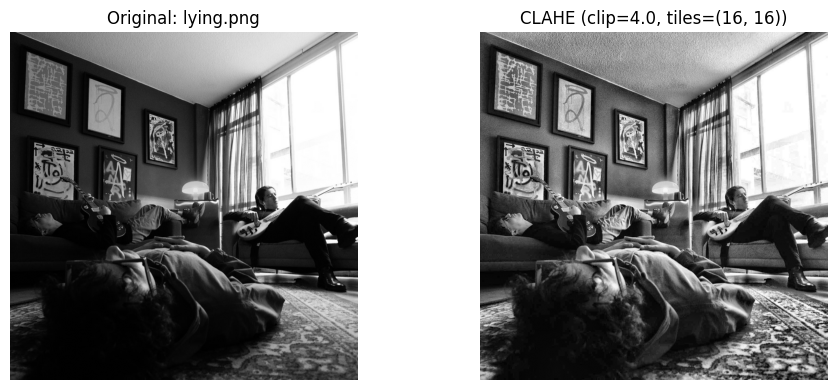

Saved: data/output_clahe/lying_CLAHE_c4.0_t16x16.png


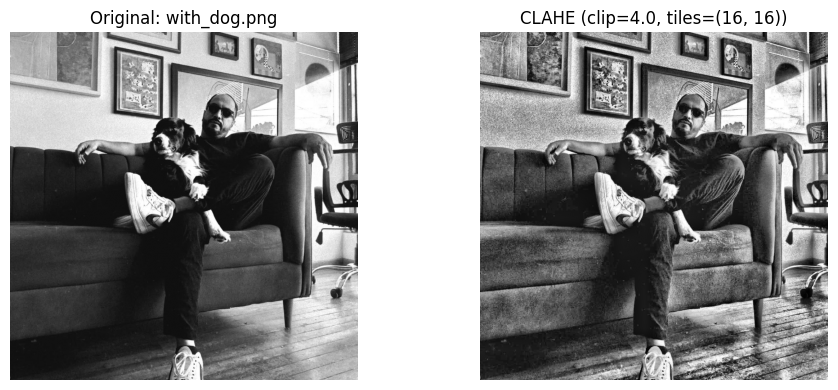

Saved: data/output_clahe/with_dog_CLAHE_c4.0_t16x16.png


In [49]:
# --- Per-image process ---
for in_path in in_paths:
    assert os.path.exists(in_path), f"File not found: {in_path}"

    # Read as grayscale (uint8)
    img = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image: {in_path}")

    # Apply CLAHE
    img_clahe = apply_clahe(img, clip_limit=clip_limit, tile_grid_size=tile_grid_size)

    # Show comparison
    show_before_after(
        img, img_clahe,
        title_before=f"Original: {os.path.basename(in_path)}",
        title_after=f"CLAHE (clip={clip_limit}, tiles={tile_grid_size})"
    )

    # Save result
    name, _ = os.path.splitext(os.path.basename(in_path))
    out_path = os.path.join(out_dir, f"{name}_CLAHE_c{clip_limit}_t{tile_grid_size[0]}x{tile_grid_size[1]}.png")
    cv2.imwrite(out_path, img_clahe)
    print("Saved:", out_path)


The Contrast Limited Adaptive Histogram Equalization (CLAHE) method is an image processing technique designed to improve local contrast without excessively amplifying noise. Unlike global equalization, CLAHE divides the image into small regions (tiles), applies adaptive histogram equalization to each one, and then combines the results through interpolation to avoid visible edges. In addition, it introduces a contrast limit (clip limit) that restricts the redistribution of intensities, preventing homogeneous areas from becoming saturated or appearing artificially enhanced. This technique is widely used in medical imaging, photographs with uneven lighting, and applications where it is necessary to highlight details without losing naturalness.

# Conclusions
In this activity, we learned to analyze images using histograms, which allows us to understand the saturation of pixels in certain tones. For example, a shift to the left indicates an underexposed image, while a shift to the right suggests an overexposed image or one with low contrast. Equalization algorithms allow us to quickly correct these images.

In addition, we tested other methods such as CLAHE and AHE/SWAHE, which help recover local details in scenes with shadows or backlighting. However, these methods can amplify noise in dark regions or introduce halos if the window used is too large. Sometimes, they also allow us to visualize details through subtraction or simply play around with the images.

Although this may be partly motivated by science fiction in movies, we must keep in mind that in real life no method “fixes” information that does not exist: if a plate is out of focus or saturated, enhancement will not reconstruct it.

# References

Stimper, V., Bauer, S., Ernstorfer, R., & Xian, R. P. (2019). Multidimensional Contrast Limited Adaptive Histogram Equalization. Max Planck Institute for Intelligent Systems. Recuperado de https://arxiv.org/pdf/1906.11355v3.pdf1.

Lagae, A. (2007). TILE-BASED METHODS IN COMPUTER GRAPHICS. Leuven: Katholieke Universiteit Leuven.

Venkatesh, S., De Britto C., J., Subhashini, P., & Somasundaram, K. (2022). Image Enhancement and Implementation of CLAHE Algorithm and Bilinear Interpolation. Cybernetics and Systems, 6,7

OpenCV. (n.d.). Histogram Equalization. OpenCV Documentation. Recuperado de https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html1

Htoon, K. S. (2020, enero 6). A tutorial to histogram equalization. Medium. Recuperado de https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e22

SpyPhuntsho, K. T. (2021, abril 10). Introduction to image processing using OpenCV in Google Colab. Medium. Recuperado de https://karmatnspyphuntsho-tijtech.medium.com/introduction-to-image-processing-using-opencv-in-google-colab-a449306cb3953

Gonzalez, R. C., & Woods, R. E. (2018). Digital image processing (4ª ed.). Pearson.